In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

# Optional: Set a professional style for the plot
plt.style.use('default')

In [2]:
def extract_melt_front_summation(file_path):
    """
    Extracts the equivalent melt front position using the Summation Method.
    
    This calculates the total liquid volume fraction in the domain and 
    converts it to a physical position. This avoids the 'staircase' error 
    caused by discrete grid cells.
    
    Parameters
    ----------
    file_path : str
        Path to the .h5 PCM dataset file
        
    Returns
    -------
    times : ndarray
        Time array
    x_front : ndarray
        Smooth melt front position vs time
    """
    with h5py.File(file_path, "r") as f:
        # Load datasets: (Time, Y, X)
        f_liq = f["case/f"][:]    
        times = f["case/times"][:] 
        x = f["case/x"][:]        

    # 1. Calculate Grid Spacing (dx)
    # We assume a uniform grid, so we take the distance between the first two points
    dx = x[1] - x[0]

    # 2. THE SUMMATION LOGIC (Vectorized for speed)
    # Step A: Average over the Y-axis (height) to get a 1D profile
    # Shape changes from (nt, ny, nx) -> (nt, nx)
    f_1d = f_liq.mean(axis=1) 
    
    # Step B: Sum all liquid fractions across the X-axis
    # Shape changes from (nt, nx) -> (nt,)
    total_liquid_cells = f_1d.sum(axis=1)
    
    # Step C: Convert 'Total Liquid Count' to 'Physical Meters'
    x_front = total_liquid_cells * dx

    return times, x_front

In [3]:
case_ids = [0, 40, 80]  # Low, medium, high heat flux cases
dataset_dir = "pcm_dataset_2D"

Processed: Case 0
Processed: Case 40
Processed: Case 80


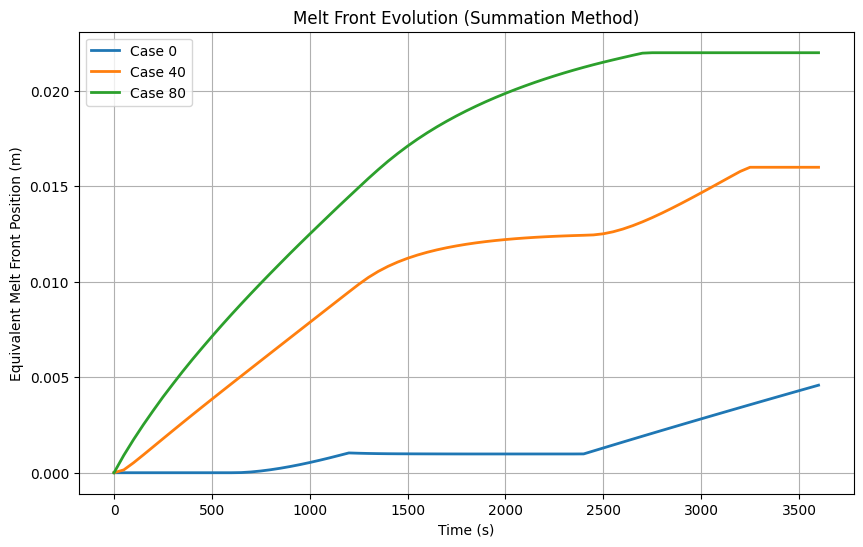

In [4]:
plt.figure(figsize=(10, 6))

for cid in case_ids:
    file = f"{dataset_dir}/pcm2D_case_{cid:04d}.h5"
    
    try:
        # Call the new Summation function
        times, x_front = extract_melt_front_summation(file)
        
        # Plot the smooth line (removed marker='o' to keep it clean)
        plt.plot(times, x_front, linewidth=2, label=f"Case {cid}")
        print(f"Processed: Case {cid}")
        
    except FileNotFoundError:
        print(f"Warning: File {file} not found")

plt.xlabel("Time (s)")
plt.ylabel("Equivalent Melt Front Position (m)")
plt.title("Melt Front Evolution (Summation Method)")
plt.legend()
plt.grid(True)
plt.show()